In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import moxing as mox

mox.file.shift('os', 'mox')
mox.file.copy_parallel('s3://lzhbucket/garbage_classify_v2', './garbage_classify')

INFO:root:Using MoXing-v1.13.0-de803ac9
INFO:root:Using OBS-Python-SDK-3.1.2
INFO:root:Listing OBS: 1000
INFO:root:Listing OBS: 2000
INFO:root:Listing OBS: 3000
INFO:root:Listing OBS: 4000
INFO:root:Listing OBS: 5000
INFO:root:Listing OBS: 6000
INFO:root:Listing OBS: 7000
INFO:root:Listing OBS: 8000
INFO:root:Listing OBS: 9000
INFO:root:Listing OBS: 10000
INFO:root:Listing OBS: 11000
INFO:root:Listing OBS: 12000
INFO:root:Listing OBS: 13000
INFO:root:Listing OBS: 14000
INFO:root:pid: None.	1000/14757
INFO:root:pid: None.	2000/14757
INFO:root:pid: None.	3000/14757
INFO:root:pid: None.	4000/14757
INFO:root:pid: None.	5000/14757
INFO:root:pid: None.	6000/14757
INFO:root:pid: None.	7000/14757
INFO:root:pid: None.	8000/14757
INFO:root:pid: None.	9000/14757
INFO:root:pid: None.	10000/14757
INFO:root:pid: None.	11000/14757
INFO:root:pid: None.	12000/14757
INFO:root:pid: None.	13000/14757
INFO:root:pid: None.	14000/14757


In [ ]:
# import pip
# from subprocess import call

# packages = [dist.project_name for dist in pip.get_installed_distributions()]
# call("pip install --upgrade --ignore-installed " + ' '.join(packages), shell=True)

In [2]:
!pip install git+https://github.com/fastai/fastai.git
!pip install pytorchcv

  Cloning https://github.com/fastai/fastai.git to /tmp/pip-m_v2mgu4-build
    100% |████████████████████████████████| 20.4MB 99.0MB/s eta 0:00:016kB 69.4MB/s eta 0:00:01                   | 5.0MB 91.2MB/s eta 0:00:01████▌                 | 9.2MB 92.1MB/s eta 0:00:01███████████████▍           | 13.0MB 81.8MB/s eta 0:00:01��██████████████████████████▎    | 17.3MB 89.0MB/s eta 0:00:01
    100% |████████████████████████████████| 30.9MB 88.8MB/s eta 0:00:01|██▏                             | 2.1MB 64.8MB/s eta 0:00:01            | 5.7MB 67.2MB/s eta 0:00:01102.7MB/s eta 0:00:01 15.2MB 73.2MB/s eta 0:00:01   | 18.4MB 86.6MB/s eta 0:00:01██████▉         | 22.0MB 93.3MB/s eta 0:00:017MB/s eta 0:00:01ta 0:00:01
    100% |████████████████████████████████| 3.2MB 101.1MB/s ta 0:00:01�██████ | 3.1MB 101.6MB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 47.8MB/s ta 0:00:01
    100% |████████████████████████████████| 2.1MB 98.6MB/s eta 0:00:01
    100% |███████████████████████████████

  Running setup.py bdist_wheel for nvidia-ml-py3 ... done
  Stored in directory: /home/ma-user/.cache/pip/wheels/06/92/d6/be09adab36ee8d9900237f2c2b240c0fc04679d9b616ab5137
Successfully built nvidia-ml-py3
  Found existing installation: numpy 1.14.5
    Uninstalling numpy-1.14.5:
      Successfully uninstalled numpy-1.14.5
  Running setup.py install for fastai ... done
You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 399kB 102.5MB/s ta 0:00:01
You are using pip version 9.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
from torchvision.models import *
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
from pytorchcv.model_provider import get_model as ptcv_get_model
from utils import *
from fastai.callbacks import SaveModelCallback
from ranger import Ranger

In [4]:
os.environ['TORCH_HOME'] = '/home/ma-user/work/'

In [5]:
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--data_url', type=str, default='./garbage_classify',
                    help=' path of dataset')
parser.add_argument('--train_url', type=str, default='./output',
                    help=' path of model')
# Protect the arguments which are not parsed.
args, unparsed = parser.parse_known_args()

In [6]:
path = Path(args.data_url);
model_path = Path(args.train_url); model_path
data_path = path/'train_data'

In [41]:
np.random.seed(42)
src = (ImageList.from_folder(path)
        .split_by_rand_pct(0.2)
        .label_from_folder())
data = (src.transform(get_transforms(flip_vert=True), size=224)
        .databunch(bs=32)
        .normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (11804 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
31,31,31,31,31
Path: garbage_classify;

Valid: LabelList (2950 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
21,2,11,33,4
Path: garbage_classify;

Test: None

In [35]:
model_name = 'efficientnet_b5b'
def getModel(pretrained=True):
    return ptcv_get_model(model_name, pretrained=pretrained, root='/home/ma-user/work/').features

In [42]:
learn = cnn_learner(data, getModel, pretrained=True,
                    cut=noop, split_on=lambda m: (m[0][4], m[1]),
                    metrics=accuracy, opt_func=Ranger,
                    bn_wd=False, true_wd=True,
                    loss_func=LabelSmoothingCrossEntropy(),
                    callback_fns=[ShowGraph])

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.00E-01
Min loss divided by 10: 3.80E-02


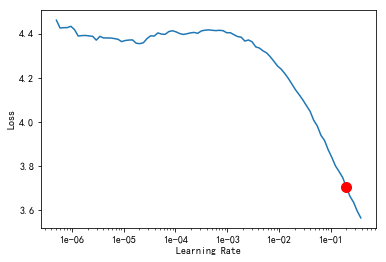

In [14]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,1.780178,1.408784,0.775254,03:06
1,1.481990,1.283811,0.820339,03:04
2,1.399929,1.201515,0.837288,03:03
3,1.306057,1.157913,0.854237,03:03
4,1.250659,1.130534,0.870170,03:03
5,1.190930,1.107270,0.868136,03:03
6,1.157147,1.079972,0.877627,03:03
7,1.142941,1.078305,0.876610,03:03
8,1.122730,1.076132,0.881017,03:03
9,1.112189,1.091986,0.870508,03:03


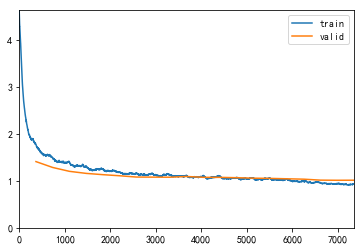

In [43]:
fit_fc(learn, tot_epochs=20, lr=1e-2, wd=1e-3)

In [44]:
learn.save('efn-1')

In [ ]:
learn.data = data

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(10, slice(1e-2))
learn.save('efn-1-1')

## 第2阶段训练
增加图像 size

In [53]:
learn = cnn_learner(data, getModel, pretrained=True,
                    cut=noop, split_on=lambda m: (m[0][4], m[1]),
                    metrics=accuracy, opt_func=Ranger,
                    bn_wd=False, true_wd=True,
                    loss_func=LabelSmoothingCrossEntropy(),
                    callback_fns=[ShowGraph])
learn.load('efn-1')

set state called


Learner(data=ImageDataBunch;

Train: LabelList (11804 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
31,31,31,31,31
Path: garbage_classify;

Valid: LabelList (2950 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
21,2,11,33,4
Path: garbage_classify;

Test: None, model=Sequential(
  (0): Sequential(
    (init_block): EffiInitBlock(
      (conv): ConvBlock(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (activ): Swish()
      )
    )
    (stage1): Sequential(
      (unit1): EffiDwsConvUnit(
        (dw_conv): ConvBlock(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), groups=48, bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_r

In [52]:
np.random.seed(42)
data = (src.transform(get_transforms(flip_vert=True), size=456)
        .databunch(bs=8)
        .normalize(imagenet_stats))

learn.data = data

AttributeError: 'NoneType' object has no attribute 'data'

set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.31E-07


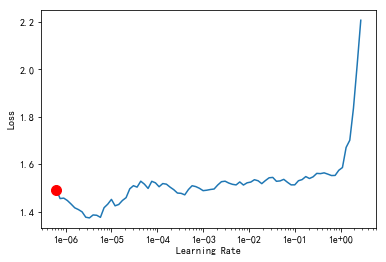

In [54]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(10, slice(1e-3))#, callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='efn-3')])
learn.save('efn-2')

## 第3阶段训练
模型解冻

In [ ]:
learn = cnn_learner(data, getModel, pretrained=True,
                    cut=noop, split_on=lambda m: (m[0][4], m[1]), metrics=accuracy,
                    loss_func=LabelSmoothingCrossEntropy()
                    callback_fns=[ShowGraph])
learn.load('efn-2')

In [ ]:
learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(10, slice(1e-5/5,1e-3/5), 
                    callbacks=[SaveModelCallback(learn, every='improvement', name='efn-2-1')])

In [ ]:
learn.save('efn-2-1')

In [ ]:
learn = cnn_learner(data, getModel, pretrained=True,
                    cut=noop, split_on=lambda m: (m[0][4], m[1]), metrics=accuracy,
                    loss_func=LabelSmoothingCrossEntropy(),
                    callback_fns=[ShowGraph])
learn.load('efn-2-1')

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, slice(1e-5,1e-3))

In [ ]:
learn.save('efn-2-2')

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, slice(1e-6,1e-4))

In [ ]:
learn.save('efn-2-2')

## 反复训练

In [9]:
learn = cnn_learner(data, getModel, pretrained=True,
                    cut=noop, split_on=lambda m: (m[0][4], m[1]), metrics=accuracy,
                    loss_func=LabelSmoothingCrossEntropy(),
                    callback_fns=[ShowGraph])
learn.load('efn-2-2')

Learner(data=ImageDataBunch;

Train: LabelList (11804 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
12,12,12,12,12
Path: garbage_classify;

Valid: LabelList (2950 items)
x: ImageList
Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456),Image (3, 456, 456)
y: CategoryList
32,7,25,14,14
Path: garbage_classify;

Test: None, model=Sequential(
  (0): Sequential(
    (init_block): EffiInitBlock(
      (conv): ConvBlock(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (bn): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (activ): Swish()
      )
    )
    (stage1): Sequential(
      (unit1): EffiDwsConvUnit(
        (dw_conv): ConvBlock(
          (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), groups=48, bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_

In [10]:
learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.919440,0.956361,0.936271,16:57
1,0.893717,0.957540,0.927119,16:53
2,0.879400,0.949568,0.932203,16:52
3,0.890164,0.958820,0.929492,16:52
4,0.931554,0.954210,0.934576,16:52


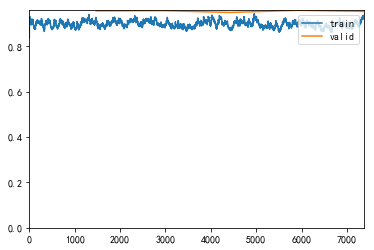

Better model found at epoch 0 with valid_loss value: 0.9563608765602112.
Better model found at epoch 2 with valid_loss value: 0.9495675563812256.


In [11]:
learn.fit_one_cycle(5, slice(1e-7,1e-5),callbacks=[SaveModelCallback(learn, every='improvement', name='efn-3')])
# learn.save('efn-3')

## over

## 特殊阶段训练
清洗数据

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(20, figsize=(15,11))

In [ ]:
interp.most_confused(min_val=5)

In [ ]:
interp.plot_confusion_matrix(figsize=(9,9), dpi=70)

In [ ]:
from fastai.widgets import *

In [ ]:
pd.read_csv(path/"cleaned.csv").head()

In [ ]:
np.random.seed(2)
src = (ImageList.from_csv(path, 'stg-1.csv')
        .split_none()
        .label_from_df(cols='y'))
db = (src.transform(get_transforms(flip_vert=True), size=300)
        .databunch(bs=32)
        .normalize(imagenet_stats))
# np.random.seed(42)
# db = ImageDataBunch.from_csv(path, folder=".", csv_labels="cleaned.csv", valid_pct=0.,
#         ds_tfms=get_transforms(flip_vert=True), size=300, bs=32).normalize(imagenet_stats)
# db

In [ ]:
db.show_batch(row=3)

In [ ]:
learn_cln = cnn_learner(db, getModel, pretrained=True,
                    cut=noop, split_on=lambda m: (m[0][4], m[1]), metrics=accuracy)
learn_cln.load('efn-6')

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln, n_imgs=100)

In [ ]:
ImageCleaner(ds, idxs, path)

In [ ]:
np.random.seed(42)
data = ImageDataBunch.from_csv(path, folder=".", csv_labels="cleaned.csv",
        ds_tfms=get_transforms(flip_vert=True), size=224, bs=64).normalize(imagenet_stats)
data

In [ ]:
learn.fit_one_cycle(5, max_lr=1e-2)
learn.save('efn-4')

## 导出模型

In [ ]:
learn.export('efficientnetb5b2-1.pth')

In [ ]:
model_path/''.ls()

In [ ]:
test_path=Path('./img_3715.jpg')

In [ ]:
img = open_image(test_path)
img

In [ ]:
# path = model_path.parent; path.ls()

In [ ]:
learn = load_learner(path, file='efficientnetb5b.pth')

In [ ]:
learn.data.classes

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)
print(pred_class,pred_idx,outputs)
pred_class
learn.data.classes[pred_idx]

In [ ]:
# pred_class,pred_idx,outputs = learn.predict('')
# len(outputs)

In [ ]:
label_id_name_dict = \
            {
                "0": "其他垃圾/一次性快餐盒",
                "1": "其他垃圾/污损塑料",
                "2": "其他垃圾/烟蒂",
                "3": "其他垃圾/牙签",
                "4": "其他垃圾/破碎花盆及碟碗",
                "5": "其他垃圾/竹筷",
                "6": "厨余垃圾/剩饭剩菜",
                "7": "厨余垃圾/大骨头",
                "8": "厨余垃圾/水果果皮",
                "9": "厨余垃圾/水果果肉",
                "10": "厨余垃圾/茶叶渣",
                "11": "厨余垃圾/菜叶菜根",
                "12": "厨余垃圾/蛋壳",
                "13": "厨余垃圾/鱼骨",
                "14": "可回收物/充电宝",
                "15": "可回收物/包",
                "16": "可回收物/化妆品瓶",
                "17": "可回收物/塑料玩具",
                "18": "可回收物/塑料碗盆",
                "19": "可回收物/塑料衣架",
                "20": "可回收物/快递纸袋",
                "21": "可回收物/插头电线",
                "22": "可回收物/旧衣服",
                "23": "可回收物/易拉罐",
                "24": "可回收物/枕头",
                "25": "可回收物/毛绒玩具",
                "26": "可回收物/洗发水瓶",
                "27": "可回收物/玻璃杯",
                "28": "可回收物/皮鞋",
                "29": "可回收物/砧板",
                "30": "可回收物/纸板箱",
                "31": "可回收物/调料瓶",
                "32": "可回收物/酒瓶",
                "33": "可回收物/金属食品罐",
                "34": "可回收物/锅",
                "35": "可回收物/食用油桶",
                "36": "可回收物/饮料瓶",
                "37": "有害垃圾/干电池",
                "38": "有害垃圾/软膏",
                "39": "有害垃圾/过期药物"
            }

In [ ]:
label_id_name_dict[str(learn.data.classes[pred_idx])]

In [ ]:
int(pred_idx)

In [ ]:
np.random.seed(2)
data = (ImageList.from_folder('./')
           .split_none()
           .label_empty()
           .transform(get_transforms(), size=300)
           .add_test([test_path])
           .databunch(bs=1)
           .normalize(imagenet_stats))
data

In [ ]:
learn.data.add_test([test_path])

In [ ]:
log_preds, y = learn.TTA(ds_type=DatasetType.Test)
log_preds

In [ ]:
pred_idx = np.argmax(log_preds.numpy())
learn.data.classes[pred_idx]

## Tools

In [51]:
learn = None
gc.collect()
torch.cuda.empty_cache()

In [ ]:
learn.

In [ ]:
m = ptcv_get_model("efficientnet_b7b", pretrained=False)

In [ ]:
arch_summary(lambda _: m.features)

In [ ]:
for i in range(6):
    print(f'---------({i})---------')
    arch_summary(lambda _: m.features[i])

In [ ]:
get_groups(nn.Sequential(*learn.model[0], *learn.model[1]), learn.layer_groups)

In [ ]:
learn.layer_groups

In [ ]:
learn.lr_find(1e-12)
learn.recorder.plot(suggestion=True)

In [ ]:
learn.model[1]

In [ ]:
learn.fit_one_cycle(5, slice(1e-8))

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
preds, target = learn.TTA()
accuracy(preds, target)

In [ ]:
learn.load('efn-1')

In [ ]:
learn.export(f"{model_name}.pth")